In [1]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# utility: modeling

# plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [3]:
# load data
sbdb_df = pd.read_csv("sbdb_query_results.csv", index_col='pdes')
sbdb_df.index = sbdb_df.index.map(lambda x: x.replace(" ", ""))
sbdb_df['pha'] = sbdb_df['pha'].apply(lambda x: 1 if x == "Y" else 0)
sbdb_df.dropna(inplace=True)
print(sbdb_df.shape)
sbdb_df.head()

(28858, 9)


,e,a,i,om,w,ma,H,moid,pha
pdes,,,,,,,,,
433,0.2227,1.458,10.83,304.30,178.90,246.90,10.31,0.1490,0
719,0.5470,2.638,11.58,183.86,156.23,278.20,15.57,0.2030,0
887,0.5705,2.473,9.39,110.43,350.49,86.61,13.87,0.0815,0
1036,0.5331,2.666,26.68,215.52,132.43,140.65,9.22,0.3450,0
1221,0.4358,1.919,11.88,171.32,26.64,261.04,17.40,0.1060,0


In [4]:
# prep data
X = sbdb_df.iloc[:, :6]
y = sbdb_df.iloc[:, 7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# model architecture
def build_moid_model():
  # inputs
  inputs = keras.Input(shape=(6,))

  # block 1
  l1 = keras.layers.Dense(32, activation='relu')(inputs)
  l2 = keras.layers.Dense(32, activation='relu')(l1)
  # l3 = keras.layers.Dense(128, activation='relu')(l2)

  # outputs
  outputs = keras.layers.Dense(1)(l2)
  model = keras.models.Model(inputs=[inputs], outputs=[outputs])
  return model

moid_model = build_moid_model()

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
moid_model.compile(optimizer=optimizer, 
                  loss="mse",
                  metrics=['mse'])

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

Epoch 1/150
136/136 [==============================] - 3s 8ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/150
136/136 [==============================] - 1s 9ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/150
136/136 [==============================] - 1s 5ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 4/150
136/136 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/150
136/136 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/150
136/136 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/150
136/136 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 8/150
136/136 [==============================] - 0s 3ms/step - 

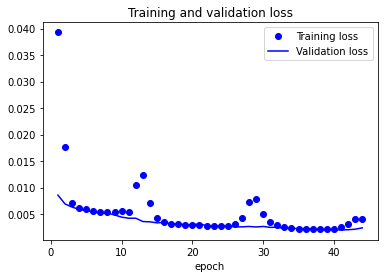

In [5]:
moid_history = moid_model.fit(X_train, y_train, validation_split=0.25, epochs=150, batch_size=128, shuffle=True, callbacks=[earlystop])
plot_training_history(moid_history)

In [6]:
# evaluation
moid_pred = moid_model.predict(X_test)
mean_squared_error(y_test, moid_pred, squared=False)

0.048145899874469184

In [19]:
rand_id = np.random.randint(moid_pred.shape[0])
print(f"Predict: {moid_pred[rand_id]}, True: {y_test[rand_id]}")

Predict: [0.01640724], True: 0.0183
